<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/Angle_%C3%B2ptim_respecteterra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alpha òptim (inclinació) = 42°
Energia anual màxima per panell = 1071.5 kWh/any


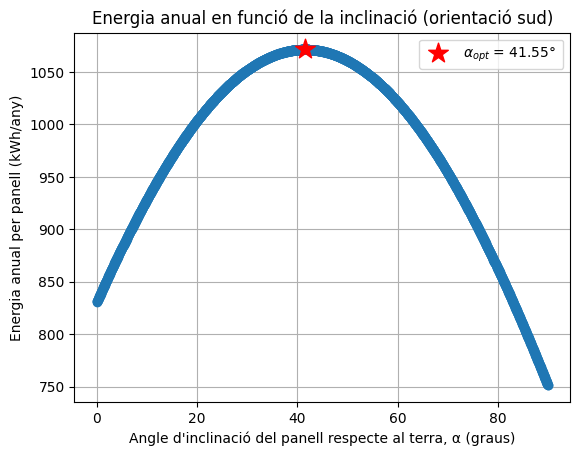

In [2]:
import numpy as np
import matplotlib.pyplot as plt

graus = np.pi / 180
latitud = (41 + 30/60 + 21/3600) * graus   # latitud Bellaterra

area_panell = 2.0       # m^2
pot_max = 400.0         # W per panell
irr_ref = 1000.0        # W/m^2

# Consum anual (kWh/any) que volem cobrir
objectiu_kWh_any = 3500.0

# Discretització temporal (un dia)
periode_dia = 24 * 3600
passos_dia = 24 * 60       # 1 minut
dt = periode_dia / passos_dia
omega = 2 * np.pi / periode_dia


# RK4 per la rotació de la Terra (eix = z)
# dv/dt = omega (k x v), amb k = ztilde
# v(t) és el vector "vertical local" (normal del panell horitzontal)
eix_rotacio = np.array([0.0, 0.0, 1.0])

def derivada_vector(t, v):
    return omega * np.cross(eix_rotacio, v)

def pas_rk4(derivada, t, v, dt):
    k1 = derivada(t, v)
    k2 = derivada(t + 0.5*dt, v + 0.5*dt*k1)
    k3 = derivada(t + 0.5*dt, v + 0.5*dt*k2)
    k4 = derivada(t + dt,     v + dt*k3)
    return v + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Normal local inicial (tria meridià y=0)
# Vector radial a latitud: [cos(latitud), 0, sin(latitud)]
normal_inicial = np.array([np.cos(latitud), 0.0, np.sin(latitud)])

# Precalcula n(t) per un dia
temps_dia = np.zeros(passos_dia + 1)
normal_dia = np.zeros((passos_dia + 1, 3))

t = 0.0
v = normal_inicial.copy()

for i in range(passos_dia + 1):
    normal_dia[i] = v / np.linalg.norm(v)
    temps_dia[i] = t
    if i < passos_dia:
        v = pas_rk4(derivada_vector, t, v, dt)
        v = v / np.linalg.norm(v)   # renormalitza
        t += dt


# Model solar anual: declinació delta(dia) i direcció del Sol s(delta)
# s es fixa durant el dia (Sol "lluny") i només canvia amb el dia de l'any.
def declinacio_solar(dia_any):
    # dia_any = 1..365 (aprox clàssica)
    return 23.44 * graus * np.sin(2*np.pi*(dia_any - 81)/365.0)

def direccio_sol_unitaria(delta):
    # Direcció del Sol en el sistema inertial:
    # al migdia solar estaria al pla x-z; fem servir s = [cosδ, 0, sinδ]
    s = np.array([np.cos(delta), 0.0, np.sin(delta)])
    return s / np.linalg.norm(s)
def energia_anual_per_panell_kWh():
    energia_any_J = 0.0
    energia_diaria_kWh = np.zeros(365)

    for dia_any in range(1, 366):
        delta = declinacio_solar(dia_any)
        sol_unit = direccio_sol_unitaria(delta)

        # cos(alpha) = n·s (panell horitzontal => normal = n)
        cos_alpha = np.dot(normal_dia, sol_unit)
        cos_alpha = np.maximum(0.0, cos_alpha)   # de nit o darrere => 0

        irr_perp = irr_ref * cos_alpha           # W/m^2 sobre el panell
        pot = pot_max * (irr_perp / irr_ref)     # escala lineal
        pot = np.minimum(pot, pot_max)           # saturació a 400 W

        energia_dia_J = np.sum(pot) * dt
        energia_any_J += energia_dia_J
        energia_diaria_kWh[dia_any - 1] = energia_dia_J / 3.6e6

    return energia_any_J / 3.6e6, energia_diaria_kWh

energia_panell_any_kWh, energia_diaria_kWh = energia_anual_per_panell_kWh()

n_panells=4


energia_total_kWh = n_panells * energia_panell_any_kWh

# Energia ANUAL EN FUNCIÓ DE LA INCLINACIÓ DEL PANELL (alpha)
# alpha = 0° horitzontal, alpha = 90° vertical
# Triem panell orientat cap al SUD (azimut sud) per maximitzar

z_tilde = np.array([0.0, 0.0, 1.0])

def sud_local_unitari(n_unit):
    # Projecta -z_tilde sobre el pla perpendicular a n_unit (pla horitzontal local)
    u = -z_tilde - np.dot(-z_tilde, n_unit) * n_unit
    norma = np.linalg.norm(u)
    if norma < 1e-12:
        # Cas límit (pol): qualsevol direcció horitzontal serveix
        return np.array([0.0, 1.0, 0.0])
    return u / norma

# Precalcula sud(t) per a tot el dia
sud_dia = np.zeros_like(normal_dia)
for i in range(normal_dia.shape[0]):
    sud_dia[i] = sud_local_unitari(normal_dia[i])

def energia_anual_per_panell_inclinacio(alpha_rad):
    energia_any_J = 0.0

    # Normal del panell inclinat: n_panell = cos(alpha)*n_local + sin(alpha)*sud_local
    n_panell_dia = (np.cos(alpha_rad) * normal_dia) + (np.sin(alpha_rad) * sud_dia)

    # Normalitza per seguretat numèrica
    normes = np.linalg.norm(n_panell_dia, axis=1)
    n_panell_dia = n_panell_dia / normes[:, None]

    for dia_any in range(1, 366):
        delta = declinacio_solar(dia_any)
        sol_unit = direccio_sol_unitaria(delta)

        cos_inc = np.dot(n_panell_dia, sol_unit)
        cos_inc = np.maximum(0.0, cos_inc)

        irr_perp = irr_ref * cos_inc
        pot = pot_max * (irr_perp / irr_ref)
        pot = np.minimum(pot, pot_max)

        energia_dia_J = np.sum(pot) * dt
        energia_any_J += energia_dia_J

    return energia_any_J / 3.6e6  # kWh/any

# Escaneig d'angles d'inclinació
pas_alpha = 0.05 # Si fem això més petit, és a dir, escanejar més angles, triga massa a compilar
alphas_graus = np.arange(0.0, 90.0 + pas_alpha, pas_alpha)
alphas_rad = alphas_graus * graus

energia_any_alpha = np.array([energia_anual_per_panell_inclinacio(a) for a in alphas_rad])

# Alpha òptim (màxim)
idx_max = np.argmax(energia_any_alpha)
alpha_optim_graus = alphas_graus[idx_max]
energia_max_kWh_any = energia_any_alpha[idx_max]

print(f"Alpha òptim (inclinació) = {alpha_optim_graus:.0f}°")
print(f"Energia anual màxima per panell = {energia_max_kWh_any:.1f} kWh/any")

# Gràfica
plt.figure()
plt.plot(alphas_graus, energia_any_alpha, marker='o', linewidth=1)
plt.scatter([alpha_optim_graus], [energia_max_kWh_any],
            marker='*', color='red', s=220, zorder=5,
            label=fr"$\alpha_{{opt}}$ = {alpha_optim_graus:.2f}° ")

plt.xlabel("Angle d'inclinació del panell respecte al terra, α (graus)")
plt.ylabel("Energia anual per panell (kWh/any)")
plt.title("Energia anual en funció de la inclinació (orientació sud)")
plt.grid(True)
plt.legend()
plt.show()

